In [1]:
import numpy as np

In [2]:
import tsmd_evaluation.benchmark_generation as gen

In [3]:
import aeon.datasets as data_loader
import locomotif.visualize as visualize
import pandas as pd

X, y = data_loader.load_classification("Symbols", split=None)
l = 398

df = pd.DataFrame(columns=['ts', 'gt'])    


np.random.seed(10)

for i in range(20):

    # Select a random class
    classes = np.unique(y)
    c = np.random.choice(classes)

    # Select a random number of motifs
    k = np.random.randint(2, 8)

    X_c = X[y == c, 0, :]

    indices = np.random.choice(len(X_c), size=k)

    ts_instances = {c: X_c[indices, :]}

    ts, gt = gen.generate_benchmark_ts_with_random_walk(25*l, ts_instances, scale=1)

    df = pd.concat([pd.DataFrame([[ts, gt]], columns=df.columns), df], ignore_index=True)

In [4]:
import statsmodels
from   statsmodels.tsa.stattools import adfuller
import tqdm

def detect_random_walk(ts, window, significance_level=0.01):
    
    ts_diff = np.diff(ts)
    n = len(ts_diff)
    is_random_walk = np.full(n, True)
    p_values = np.full(n-window+1, np.nan)

    for i in tqdm.tqdm(range(n-window+1)):
        _, p_values[i], *_ = adfuller(ts_diff[i:i+window], autolag="BIC")
        if p_values[i] > significance_level:
            is_random_walk[i:i+window] = False
    
    # Return the random walk segments
    return is_random_walk, p_values

def detect_motifs_in_random_walk(ts, l):

    is_random_walk, _ = detect_random_walk(ts, l)

    def to_segments(bits):
        diff = np.diff(bits)
        ss = np.flatnonzero(diff ==  1) + 1
        es = np.flatnonzero(diff == -1) + 1
        if bits[0]:
            ss = np.concatenate(([0], ss))
        if bits[-1]:
            n = len(bits)
            es = np.concatenate((es, [n]))
        return np.vstack((ss, es)).T

    motifs = to_segments((~is_random_walk).astype(int))
    return motifs

In [5]:
import os
import tsmd_evaluation.prom as prom

df['motif_sets'] = df['ts'].apply(lambda ts: [detect_motifs_in_random_walk(ts, (l+1)//2)])
df.to_pickle(os.path.join(".", "random_walk_symbols_results.pkl"))
df_mm = df.apply(lambda row: prom.matching_matrix(row["gt"], row["motif_sets"])[0], axis=1)
df["F1-score"] = df_mm.apply(prom.micro_averaged_f1)
print(df["F1-score"].mean())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9751/9751 [00:58<00:00, 166.16it/s]


0.976923076923077


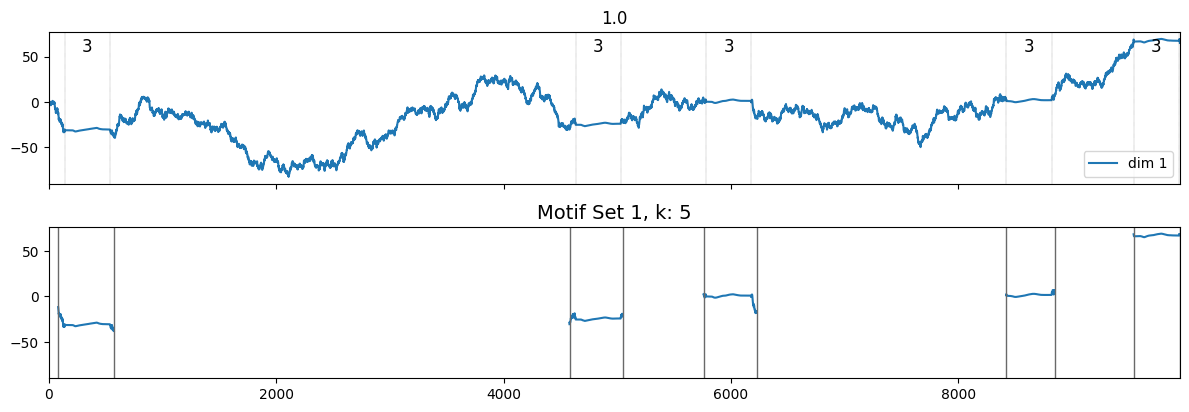

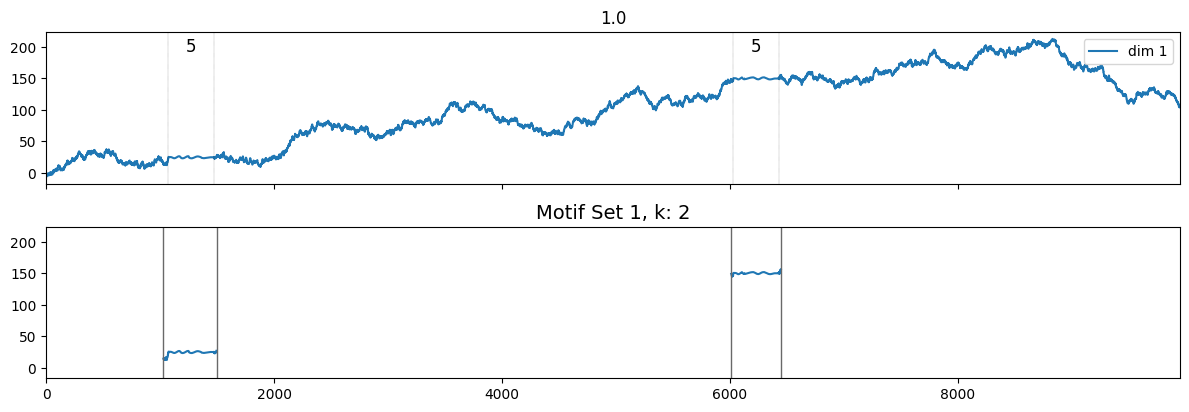

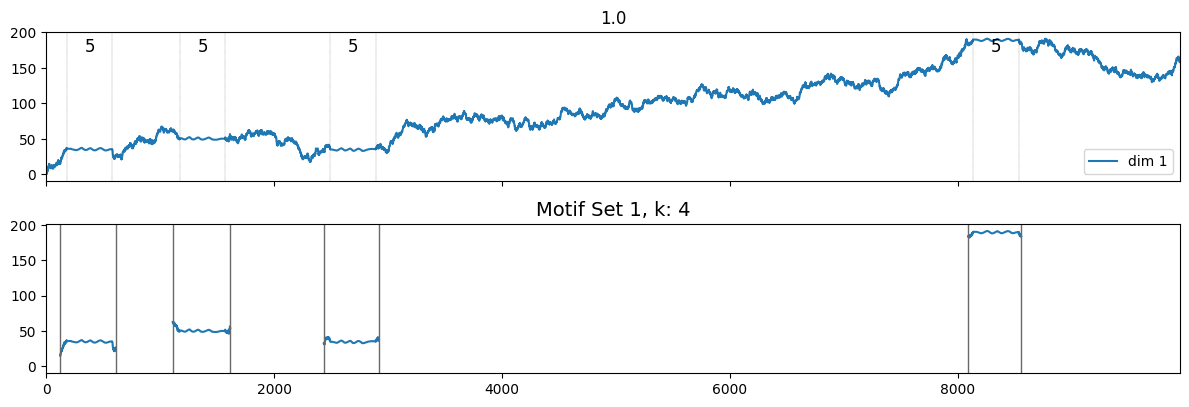

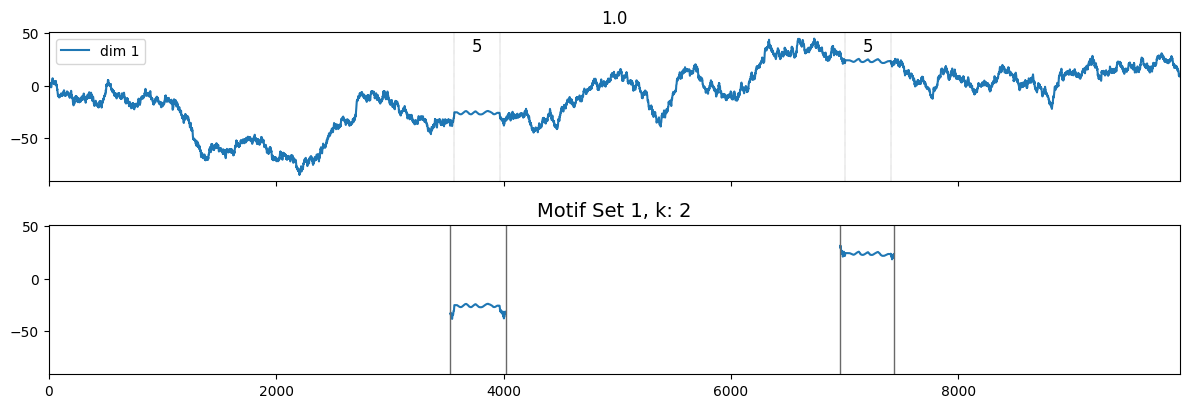

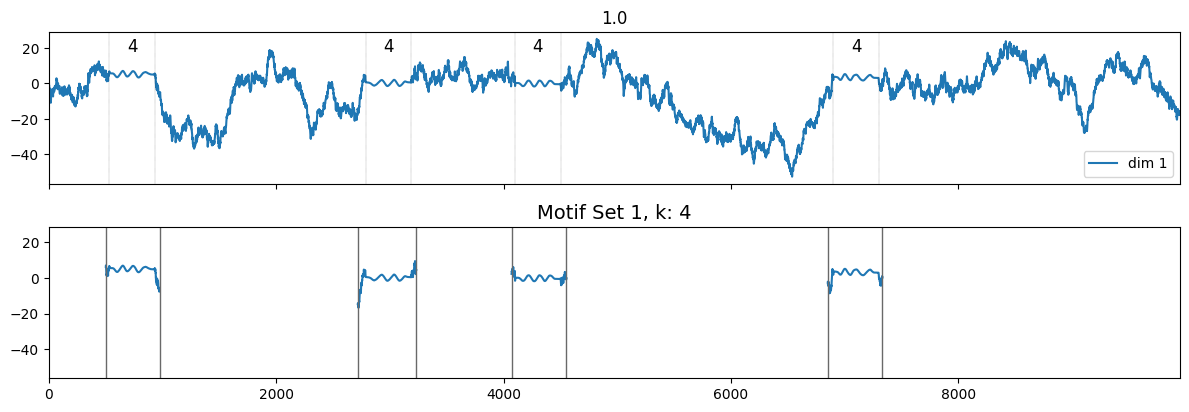

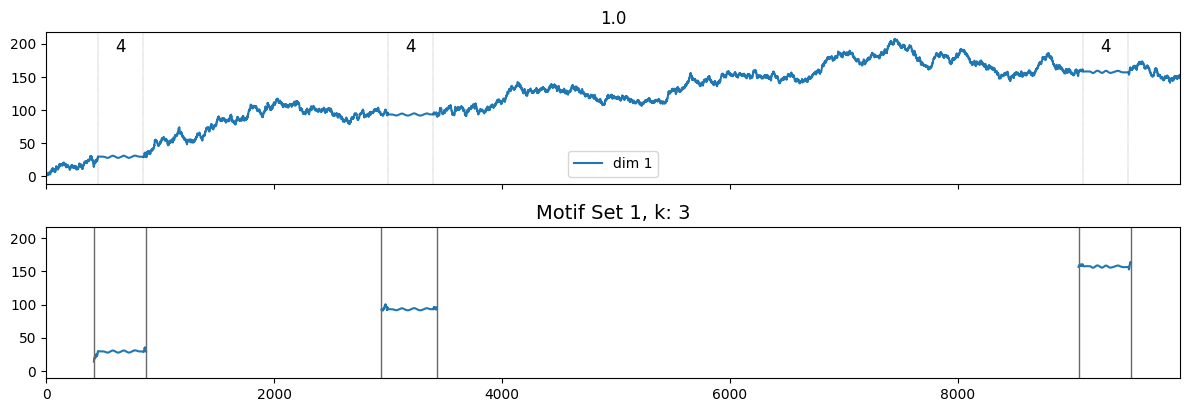

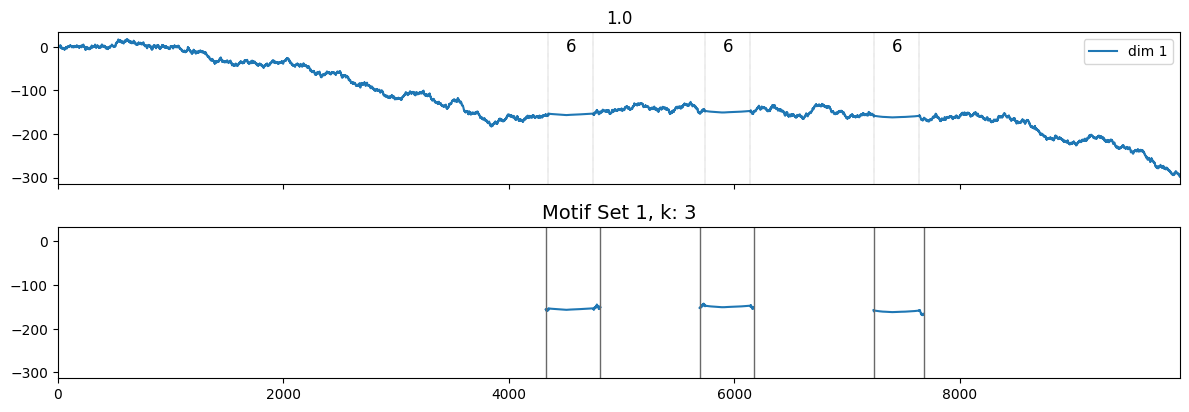

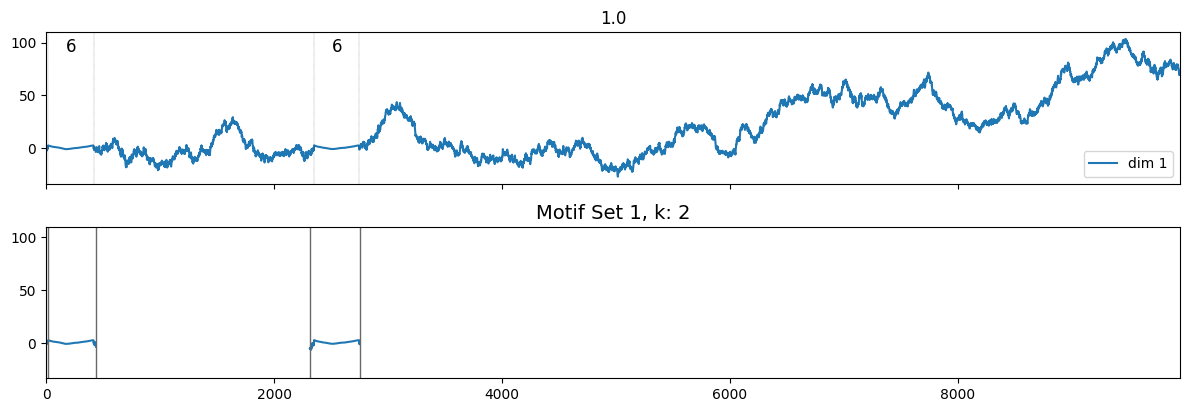

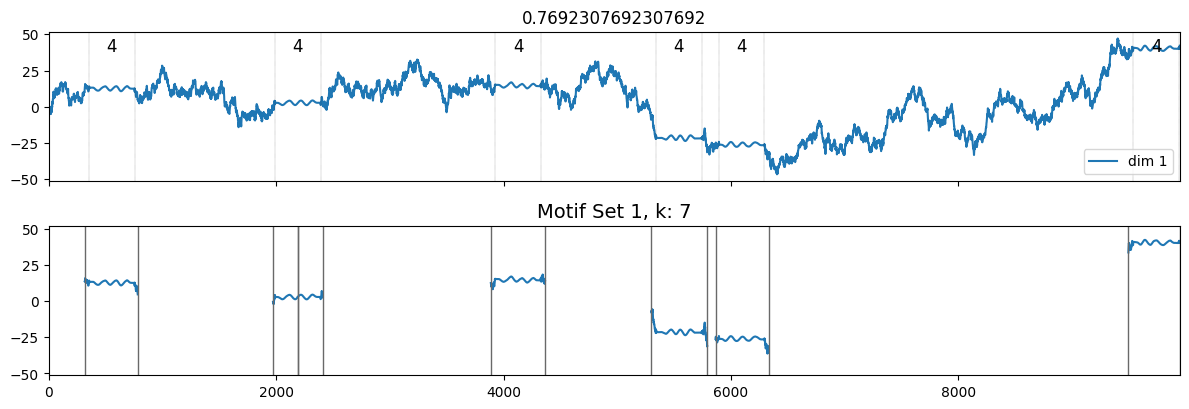

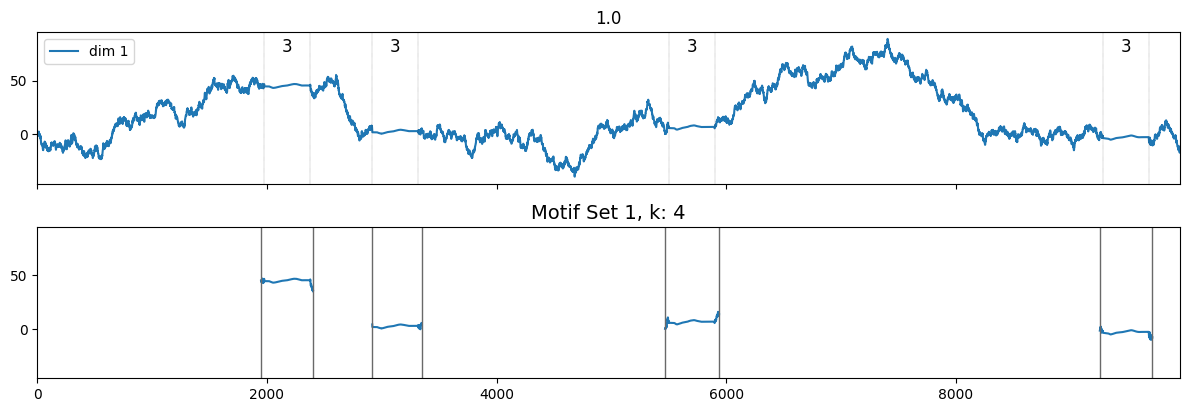

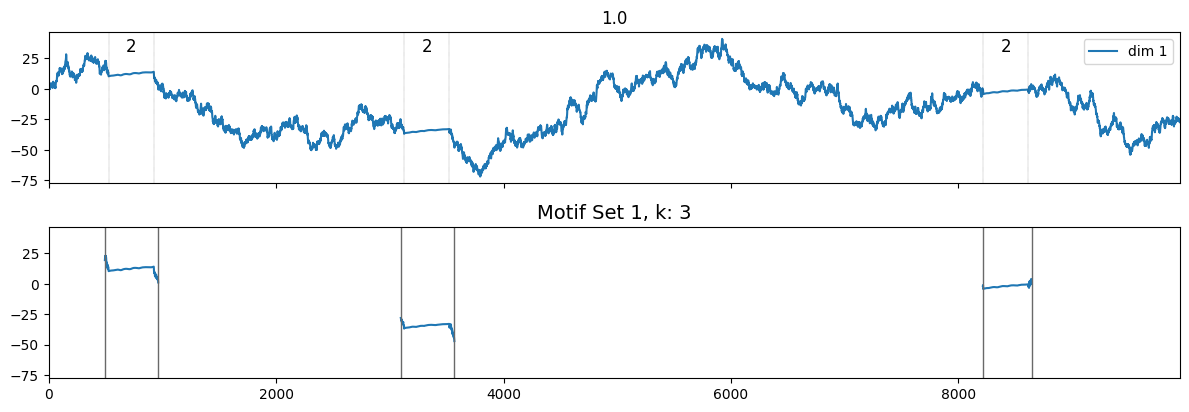

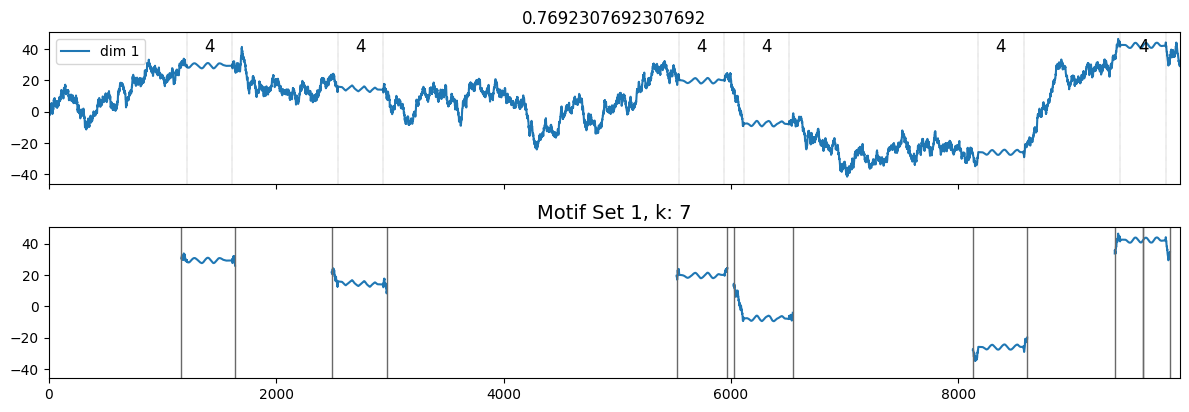

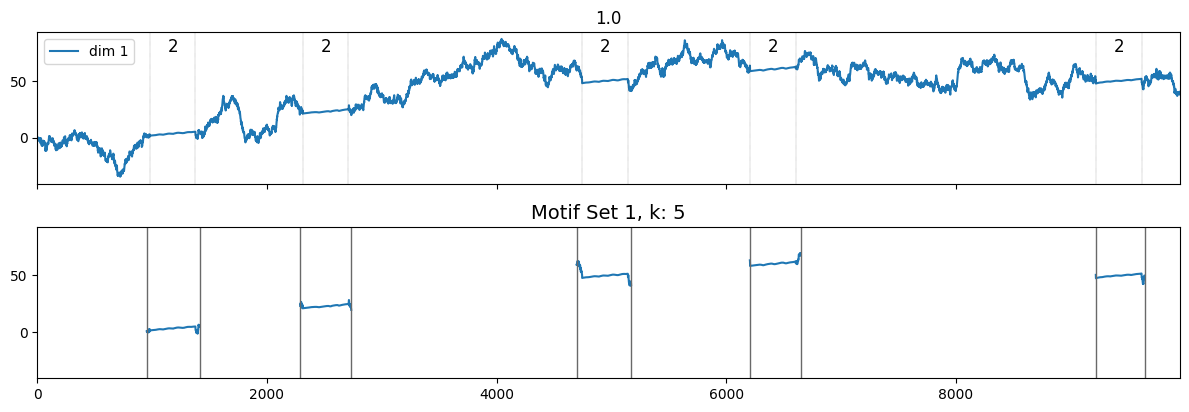

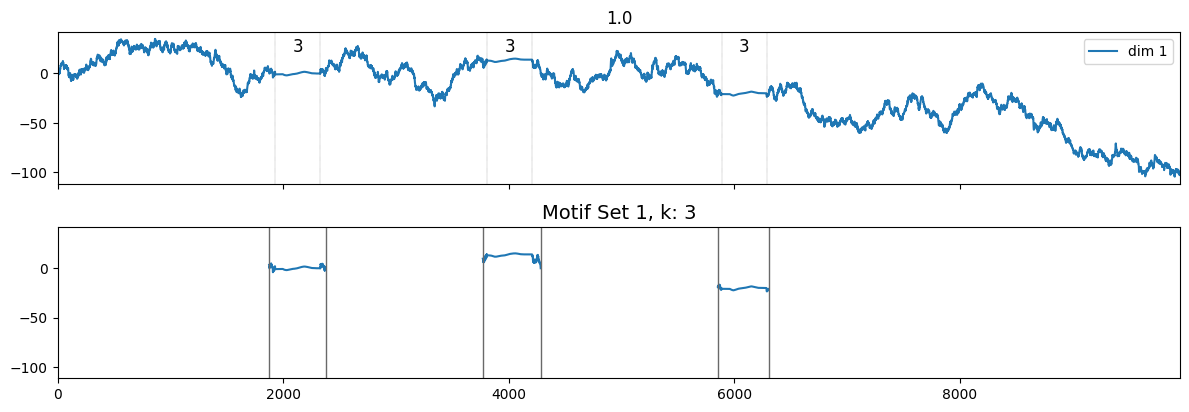

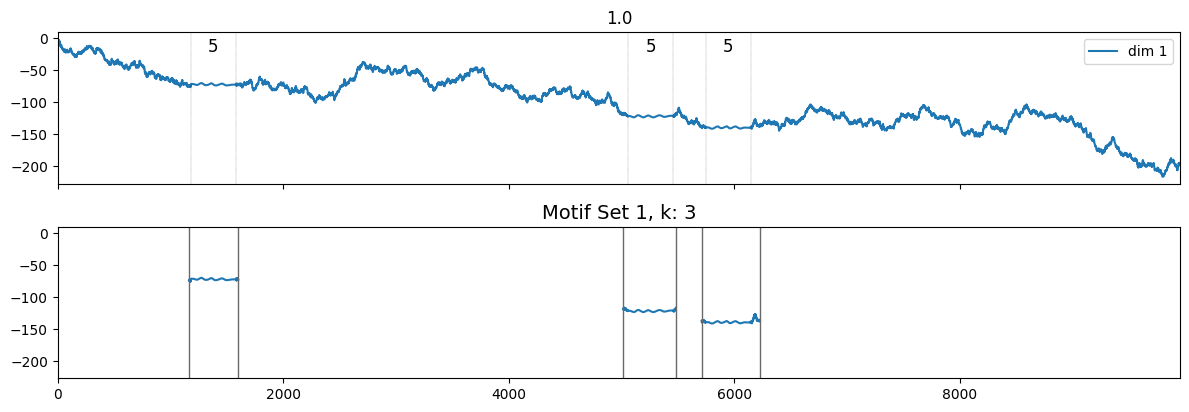

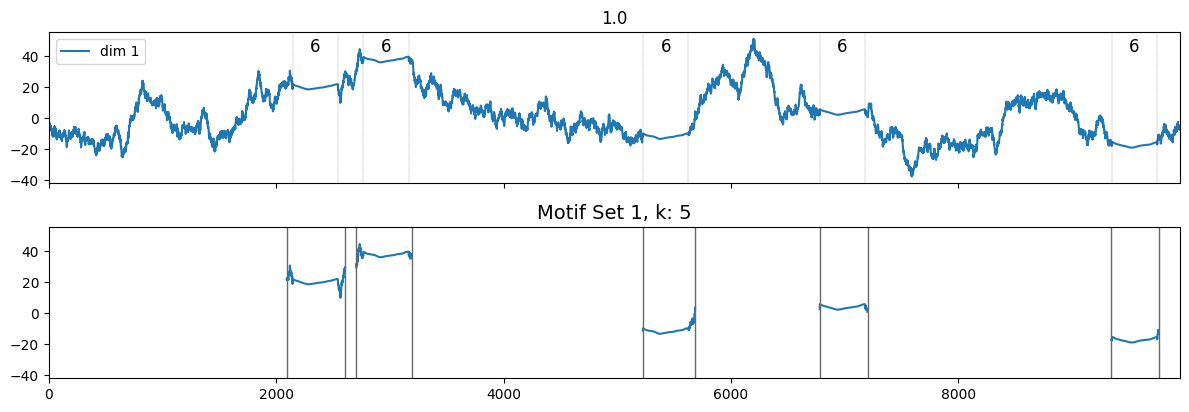

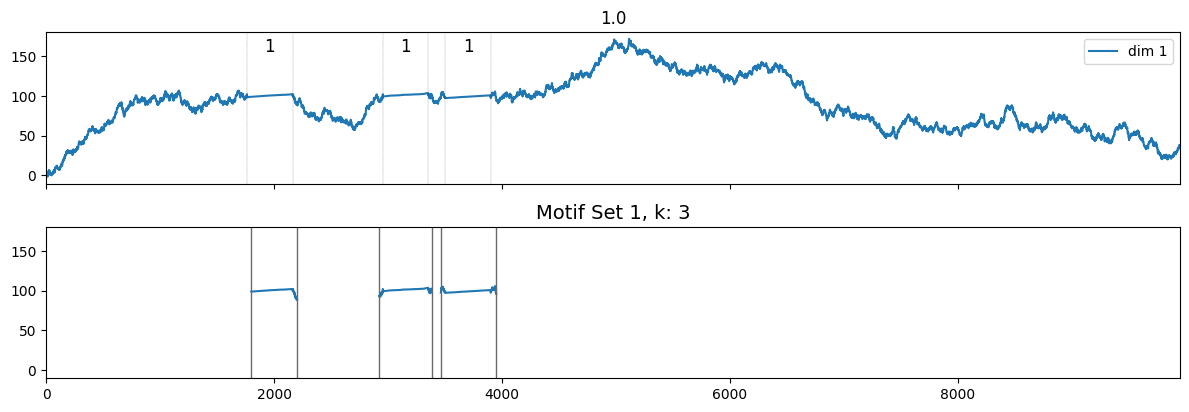

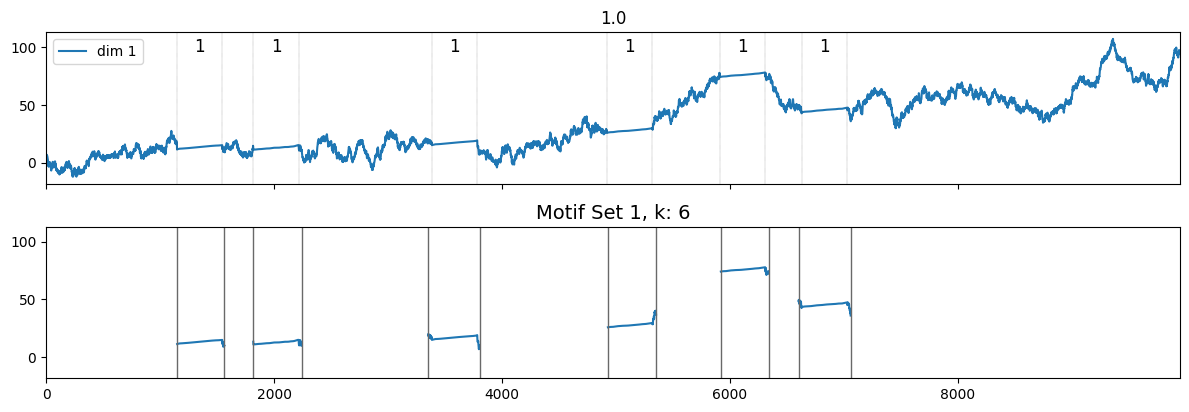

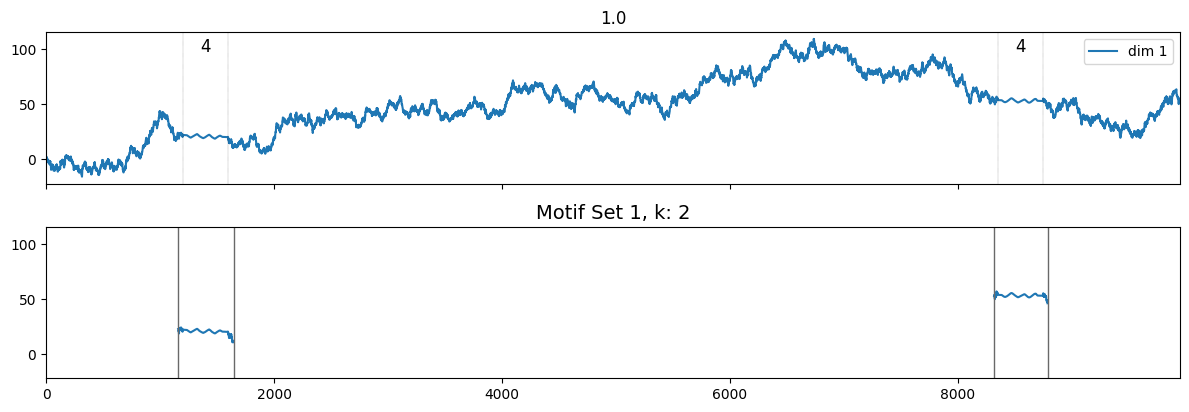

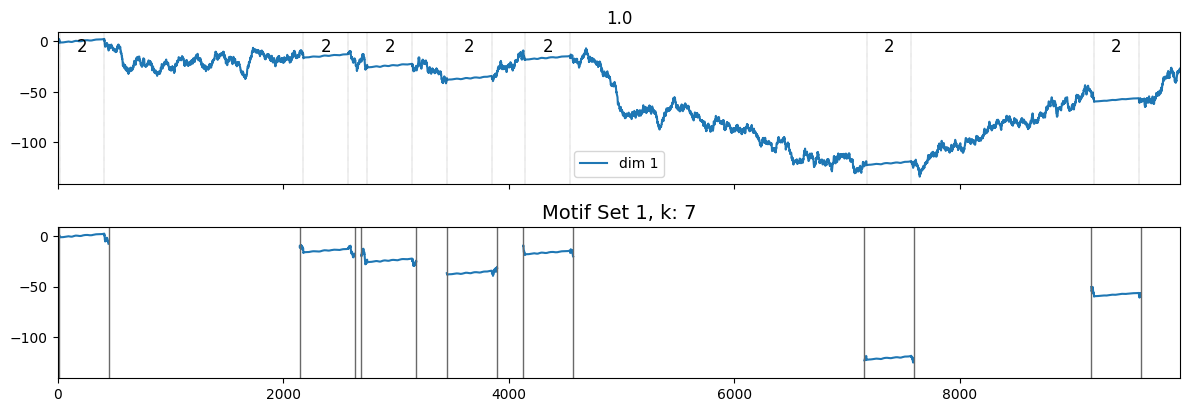

In [7]:
import locomotif.visualize as visualize
for i in range(len(df)):
    ts, gt, motif_sets, f1 = df.iloc[i]
    fig, ax = visualize.plot_motif_sets(ts, motif_sets, gt=gt)
    ax[0].set_title(f1)